1) Bùi Văn Thống - 52100934
2) Trần Văn Phát - 52100909
3) Nguyễn Minh Phú - 52100920

## Phần demo các model Học Máy cơ bản và 2 Neural Network là Feed Forward Neural Network và Recurrent Neural Network

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plotter
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('./TrafficTwoMonth.csv')

In [6]:
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal
...,...,...,...,...,...,...,...,...,...
5947,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
5948,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
5949,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
5950,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


Target của dataset này là "Traffic Situation" trong đó có 4 lớp

In [7]:
np.unique(df['Traffic Situation'].values)

array(['heavy', 'high', 'low', 'normal'], dtype=object)

### Spliting dataset

Tách thành tập train và test, để dành cho việc tách tập train thành 1 tập validation sau này

In [8]:
Train, Test = train_test_split(df, test_size=0.25,random_state=2022)

In [9]:
print("Shape of train: ", Train.shape)
print("Shape of test", Test.shape)

Shape of train:  (4464, 9)
Shape of test (1488, 9)


### Preprocessing

Biểu đồ dưới đây nhằm mục đích đánh số cho các feature và target thuộc categorical là "Day of the week" và "Traffic Situation" 

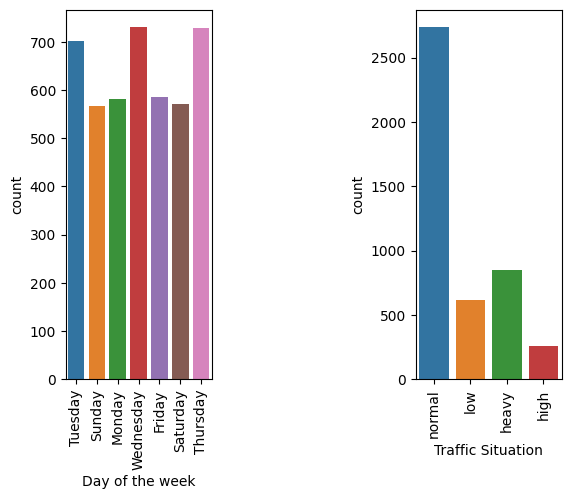

In [10]:
plt.subplot(1, 3, 1)
sns.countplot(x = Train["Day of the week"])
plotter.xticks(rotation = 90)
plt.subplot(1, 3, 3)
sns.countplot(x = Train["Traffic Situation"])
plotter.xticks(rotation = 90)
plt.show()

Trong dataset này 2 categorial features là "Time" và "Day of the week" và một target cũng có categorical.\
Thông thường với các categorical features dạng thứ thứ bậc ta có thể dùng OrdinalEncoder trong sklearn để thực hiện việc encode. \
OrdinalEncoder giúp ta có thể encode n categories trong 1 categorical feature thành các số nguyên từ 0 đến n - 1. \
Tuy nhiên, OrdinalEncoder encode các categories một cách ngẫu nhiên.

In [11]:
from sklearn.preprocessing import OrdinalEncoder

In [12]:
tmpTrain = Train

enc  = OrdinalEncoder()
enc.fit_transform(np.array([tmpTrain['Day of the week']]).reshape(-1, 1))
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in day_of_week :
    print(f'Category: {day} -> Encode {enc.transform(np.array([[day]]).reshape(-1, 1))}')

Category: Monday -> Encode [[1.]]
Category: Tuesday -> Encode [[5.]]
Category: Wednesday -> Encode [[6.]]
Category: Thursday -> Encode [[4.]]
Category: Friday -> Encode [[0.]]
Category: Saturday -> Encode [[2.]]
Category: Sunday -> Encode [[3.]]


Vì mục tiêu là dự đoán chính xác, chúng tôi cài đặt thủ công về việc encode "Day of the week" thủ công. \
Tương tự đối với target "Traffic Situation", ta cũng có thể encode bằng LabelEncoder trong sklearn, tuy nhiên vẫn phải encode thủ công.\
Còn với feature "Time" ta có thể dùng OrdinalEncoder (hoặc LabelEncoder) để thực hiện encode.

In [13]:
day_of_week_enc = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

traffic_sistuation = {
    'low': 0,
    'normal': 1,
    'high': 2, 
    'heavy':3
}

In [14]:
enc = OrdinalEncoder()

df_temp_Train = Train
df_temp_Test = Test

df_temp_Train['Day of the week'] = df_temp_Train['Day of the week'].replace(day_of_week_enc)
df_temp_Train['Time'] =  enc.fit_transform(np.array([df_temp_Train['Time']]).reshape(-1, 1)).reshape(-1)
df_temp_Train['Traffic Situation'] = df_temp_Train['Traffic Situation'].replace(traffic_sistuation)

df_temp_Test['Day of the week'] = df_temp_Test['Day of the week'].replace(day_of_week_enc)
df_temp_Test['Time'] =  enc.transform(np.array([df_temp_Test['Time']]).reshape(-1, 1)).reshape(-1)
df_temp_Test['Traffic Situation'] = df_temp_Test['Traffic Situation'].replace(traffic_sistuation)

Train = df_temp_Train
Test = df_temp_Test

In [15]:
Train

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
5703,94.0,7,2,31,10,40,9,90,1
521,2.0,15,7,46,5,11,13,75,0
2013,11.0,30,1,9,1,0,31,41,1
4808,32.0,29,7,18,4,1,31,54,1
5637,59.0,6,1,119,28,46,9,202,3
...,...,...,...,...,...,...,...,...,...
5809,19.0,8,3,69,10,4,24,107,1
4720,48.0,28,6,18,3,0,17,38,0
173,75.0,11,3,72,1,9,32,114,2
1244,9.0,22,7,8,1,1,22,32,1


Sau khi đã thực hiện việc encode các categorical features. Bước tiếp theo là scale data về một khoảng nào đó để dễ tính toán.\
Chúng tôi, xin sử dụng StandardScaler trong sklearn đễ thực hiện.\
Đầu tiên cần tách thêm một lần nữa 2 tập Train, Test thành X_Train, y_train, X_test, y_test.

In [16]:
X_train = Train.drop(['Traffic Situation'], axis=1).values
y_train = Train['Traffic Situation'].values

X_test = Test.drop(['Traffic Situation'], axis=1).values
y_test = Test['Traffic Situation'].values

In [17]:
print('X_train:')
print(X_train)
print('='*64)

print('y_train:')
print(y_train)
print('='*64)

print('X_test:')
print(X_test)
print('='*64)

print('y_test:')
print(y_test)
print('='*64)

X_train:
[[ 94.   7.   2. ...  40.   9.  90.]
 [  2.  15.   7. ...  11.  13.  75.]
 [ 11.  30.   1. ...   0.  31.  41.]
 ...
 [ 75.  11.   3. ...   9.  32. 114.]
 [  9.  22.   7. ...   1.  22.  32.]
 [ 11.  30.   1. ...   0.  27.  42.]]
y_train:
[1 0 1 ... 2 1 1]
X_test:
[[ 85.  28.   6. ...  15.  32. 129.]
 [ 17.  22.   7. ...   1.  26.  91.]
 [ 69.   7.   2. ...  11.  32. 108.]
 ...
 [ 95.  29.   7. ...   2.  29.  38.]
 [ 57.  16.   1. ...  33.  13. 184.]
 [  2.  20.   5. ...  16.  10. 153.]]
y_test:
[2 1 1 ... 1 3 1]


Tiếp theo đây sẽ scale các tập X.

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7
0,1.690340,-1.001728,-0.981514,-0.775747,-0.191491,2.178304,-0.881356,-0.347881
1,-1.647204,-0.106490,1.603734,-0.440935,-0.628289,-0.152152,-0.514344,-0.616231
2,-1.320705,1.572081,-1.498563,-1.266804,-0.977727,-1.036118,1.137213,-1.224491
3,-0.558874,1.460176,1.603734,-1.065917,-0.715648,-0.955758,1.137213,-0.991921
4,0.420622,-1.113633,-1.498563,1.188481,1.380983,2.660467,-0.881356,1.655799
...,...,...,...,...,...,...,...,...
4459,-1.030484,-0.889823,-0.464464,0.072443,-0.191491,-0.714676,0.494941,-0.043751
4460,0.021568,1.348271,1.086684,-1.065917,-0.803008,-1.036118,-0.147331,-1.278161
4461,1.001065,-0.554109,-0.464464,0.139405,-0.977727,-0.312873,1.228966,0.081479
4462,-1.393260,0.676843,1.603734,-1.289125,-0.977727,-0.955758,0.311434,-1.385501


### Sử dụng các models học máy cơ bản

Vì vấn đề trong bài toán này là Classification, nên chúng tôi sẽ sử dụng các mô hình học máy giải quyết về vấn đề classification.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC

Chúng tôi cũng sử dụng classification_report để đáng giá các model

In [22]:
from sklearn.metrics import classification_report

Để đảm bảo tính công bằng các model sẽ không được cài đặt (configure) các tham số mà chỉ để các tham số ở mặc định

In [23]:
clfs = [
    KNeighborsClassifier(), 
    LogisticRegression(), 
    GaussianNB(), 
    RandomForestClassifier(), 
    AdaBoostClassifier(), 
    GradientBoostingClassifier(), 
    BaggingClassifier(), 
    SVC()
]

In [24]:
for clf in clfs:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf)
    print(classification_report(y_test, y_pred))
    print('='*64)

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       219
           1       0.90      0.96      0.93       874
           2       0.76      0.49      0.60       110
           3       0.93      0.93      0.93       285

    accuracy                           0.90      1488
   macro avg       0.88      0.81      0.84      1488
weighted avg       0.90      0.90      0.90      1488

LogisticRegression()
              precision    recall  f1-score   support

           0       0.84      0.74      0.78       219
           1       0.87      0.94      0.91       874
           2       0.77      0.40      0.53       110
           3       0.96      0.98      0.97       285

    accuracy                           0.88      1488
   macro avg       0.86      0.77      0.80      1488
weighted avg       0.88      0.88      0.87      1488

GaussianNB()
              precision    recall  f1-score   support

           0      

Các mô hình Học Máy cơ bản có tỉ lệ dự đoán đúng cao, ví dụ như ở chỉ số accurancy của các mô hình luôn nằm trong khoảng từ 0.8 đến 1.0.\
Trong đó các mô hình dự đoán cao nhất có accuracy là 1.0 là Random Forest Classifier, Gradient Boosting Classifier, Bagging Classifier.\
Tiếp theo hãy thực nghiệm dữ liệu với Feed Forward Neural Network và Recurrent Neural Network.

### Sử dụng Feed Forward Neural Network và Recurrent Neural Network

#### Feed Forward Neural Network (FFNN)

In [25]:
import tensorflow as tf
import keras
from keras import layers

In [26]:
model = keras.models.Sequential([
    layers.Dense(16, activation='relu', input_dim=X_train.shape[1]),
    layers.Dense(32, activation='relu'),
    layers.Dense(4, activation='softmax') # target có 4 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Vì vấn đề là classification, và output layer có activation là softmax, nên target cần phải encode theo onehot (có thể dùng dummy, hoặc to_categorial của keras.utils).\
Ở đây chúng tôi xin sử dụng to_categorical trong keras.utils.

In [27]:
import copy
from keras.utils import to_categorical
y_train_tmp = copy.copy(y_train)
y_train_tmp = to_categorical(y_train_tmp)
y_train_onehot = y_train_tmp

Training FFNN

In [28]:
model.fit(X_train, y_train_onehot, epochs=200, batch_size=100, verbose=2)

Epoch 1/200
45/45 - 1s - loss: 1.2035 - accuracy: 0.4716 - 1s/epoch - 23ms/step
Epoch 2/200
45/45 - 0s - loss: 0.8363 - accuracy: 0.7238 - 135ms/epoch - 3ms/step
Epoch 3/200
45/45 - 0s - loss: 0.6453 - accuracy: 0.7603 - 61ms/epoch - 1ms/step
Epoch 4/200
45/45 - 0s - loss: 0.5263 - accuracy: 0.8129 - 141ms/epoch - 3ms/step
Epoch 5/200
45/45 - 0s - loss: 0.4330 - accuracy: 0.8466 - 57ms/epoch - 1ms/step
Epoch 6/200
45/45 - 0s - loss: 0.3678 - accuracy: 0.8750 - 45ms/epoch - 1ms/step
Epoch 7/200
45/45 - 0s - loss: 0.3234 - accuracy: 0.8880 - 48ms/epoch - 1ms/step
Epoch 8/200
45/45 - 0s - loss: 0.2920 - accuracy: 0.8981 - 46ms/epoch - 1ms/step
Epoch 9/200
45/45 - 0s - loss: 0.2693 - accuracy: 0.9012 - 49ms/epoch - 1ms/step
Epoch 10/200
45/45 - 0s - loss: 0.2515 - accuracy: 0.9075 - 64ms/epoch - 1ms/step
Epoch 11/200
45/45 - 0s - loss: 0.2390 - accuracy: 0.9104 - 103ms/epoch - 2ms/step
Epoch 12/200
45/45 - 0s - loss: 0.2279 - accuracy: 0.9164 - 74ms/epoch - 2ms/step
Epoch 13/200
45/45 - 0s

Tóm tắt các thông tin sau khi train

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 820 (3.20 KB)
Trainable params: 820 (3.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Predict

In [30]:
y_pred = model.predict(X_test)
y_pred

47/47 [==============================] - 0s 1ms/step


array([[1.8843143e-09, 4.1070789e-02, 9.5892918e-01, 9.1497384e-18],
       [3.4597114e-13, 1.0000000e+00, 2.5276331e-13, 0.0000000e+00],
       [2.1379157e-11, 9.9572217e-01, 4.2778552e-03, 7.6360802e-28],
       ...,
       [1.7762440e-30, 1.0000000e+00, 3.0628460e-34, 0.0000000e+00],
       [1.8048762e-11, 1.2049502e-02, 3.7998224e-03, 9.8415065e-01],
       [1.5241007e-04, 9.9553704e-01, 4.3102498e-03, 4.0024193e-07]],
      dtype=float32)

Với mỗi hàng trong ma trận trên chính là xác xuất của từng class khi model dự đoán 1 input.\
Với mỗi hàng ta sẽ lấy index của element có giá trị lớn nhất, index này cũng chính là class mà model dự đoán cho 1 input.

In [31]:
y_pred = y_pred.argmax(axis=1)
y_pred

array([2, 1, 1, ..., 1, 3, 1], dtype=int64)

Ta thấy rằng model FFNN này có tỉ lệ dự đóan của model này ở mức cao lên đến 99%.

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       219
           1       0.98      0.99      0.99       874
           2       0.93      0.88      0.91       110
           3       0.99      0.98      0.98       285

    accuracy                           0.98      1488
   macro avg       0.97      0.96      0.96      1488
weighted avg       0.98      0.98      0.98      1488



#### Recurrent Neural Network

Vì dataset này không dành cho RNN model, nên chúng tôi giả định rằng target "Traffic Situation" chính là input cho RNN model.
- Trường hợp 1: với giả định vấn đề của bài là dành cho Time-Series (như dự đoán giá cỗ phiếu, thời tiết,...), nghĩa là coi từng input "Traffic Situation" đi theo mốc thời gian (gộp các 30 input thành 1 input ý nghĩa là 30 ngày).
- Trường hợp 2: với giả định vấn đề của bài là dành cho Bag-Of-Words, nghĩa là gộp 30 input "Traffic Situation" thành 1 vector (đã onehot encode từng classes), coi nó như một text, sau đó dự đoán từ tiếp theo có trong đoạn text.

#### Trường hợp 1:

Như Dataframe dưới đây, ta thấy rằng vì dataset này không có datetime cụ thể (thiếu tháng, năm) nên chúng tôi sẽ viết một function để generate datetime, datetime là một điều kiện để thực hiện RNN model cho time-series.

In [33]:
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal
...,...,...,...,...,...,...,...,...,...
5947,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
5948,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
5949,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
5950,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


Hàm generate datetime

In [34]:
from datetime import datetime, timedelta

def generate_datetime(input_time, input_date, input_day_of_week, year=2023, month=12):
    # Mapping of weekday to integer
    weekday_to_int = {
        'Monday': 0,
        'Tuesday': 1,
        'Wednesday': 2,
        'Thursday': 3,
        'Friday': 4,
        'Saturday': 5,
        'Sunday': 6
    }

    # Convert time string to datetime object
    time_object = datetime.strptime(input_time, '%I:%M:%S %p')

    # Create a datetime object with the input date and time
    dt = datetime(year=year, month=month, day=input_date, hour=time_object.hour, minute=time_object.minute, second=time_object.second)

    # Calculate the difference between the desired and current weekday
    weekday_diff = weekday_to_int[input_day_of_week] - dt.weekday()
    if weekday_diff < 0:
        # If the desired weekday is before the current date, move to the next week
        weekday_diff += 7

    # Create the final datetime object
    final_dt = dt + timedelta(days=weekday_diff)

    return final_dt

Vì chỉ sử dụng target "Traffic Situation" làm input nên loại bỏ các features của dataset này.\
Tuy nhiên, vẫn để lại các features về thời gian để tạo ra cột index datetime, sau này sẽ xóa sau.

In [35]:
import copy 
new_df = copy.copy(df)

In [36]:
new_df = new_df.drop(["CarCount", "BikeCount", "BusCount", "TruckCount", "Total"], axis=1)
new_df

,Time,Date,Day of the week,Traffic Situation
0,12:00:00 AM,10,Tuesday,normal
1,12:15:00 AM,10,Tuesday,normal
2,12:30:00 AM,10,Tuesday,normal
3,12:45:00 AM,10,Tuesday,normal
4,1:00:00 AM,10,Tuesday,normal
...,...,...,...,...
5947,10:45:00 PM,9,Thursday,normal
5948,11:00:00 PM,9,Thursday,normal
5949,11:15:00 PM,9,Thursday,normal
5950,11:30:00 PM,9,Thursday,normal


Bắt đầu tạo cột Datetime

In [37]:
new_df2 = copy.copy(new_df)
new_df2['Datetime'] = new_df2.apply(lambda x: generate_datetime(x['Time'], x['Date'], x['Day of the week']), axis=1) 
new_df2

,Time,Date,Day of the week,Traffic Situation,Datetime
0,12:00:00 AM,10,Tuesday,normal,2023-12-12 00:00:00
1,12:15:00 AM,10,Tuesday,normal,2023-12-12 00:15:00
2,12:30:00 AM,10,Tuesday,normal,2023-12-12 00:30:00
3,12:45:00 AM,10,Tuesday,normal,2023-12-12 00:45:00
4,1:00:00 AM,10,Tuesday,normal,2023-12-12 01:00:00
...,...,...,...,...,...
5947,10:45:00 PM,9,Thursday,normal,2023-12-14 22:45:00
5948,11:00:00 PM,9,Thursday,normal,2023-12-14 23:00:00
5949,11:15:00 PM,9,Thursday,normal,2023-12-14 23:15:00
5950,11:30:00 PM,9,Thursday,normal,2023-12-14 23:30:00


Xóa các features về thời gian, sử dụng cột datetime là index và sort input theo thời gian.

In [38]:
new_df3 = new_df2.set_index('Datetime')
new_df4 = new_df3.drop(['Time', 'Date', 'Day of the week'], axis=1)
new_df4.sort_values(by=['Datetime'], inplace=True)

Encode Traffic Situation

In [39]:
new_df4['Traffic Situation'] = new_df4['Traffic Situation'].replace(traffic_sistuation)
new_df4

,Traffic Situation
Datetime,
2023-12-06 00:00:00,1
2023-12-06 00:00:00,1
2023-12-06 00:15:00,1
2023-12-06 00:15:00,1
2023-12-06 00:30:00,0
...,...
2024-01-02 23:15:00,1
2024-01-02 23:30:00,0
2024-01-02 23:30:00,1


Plot thử 500 Traffic Situation theo thời gian

In [40]:
import matplotlib.pyplot as plt 

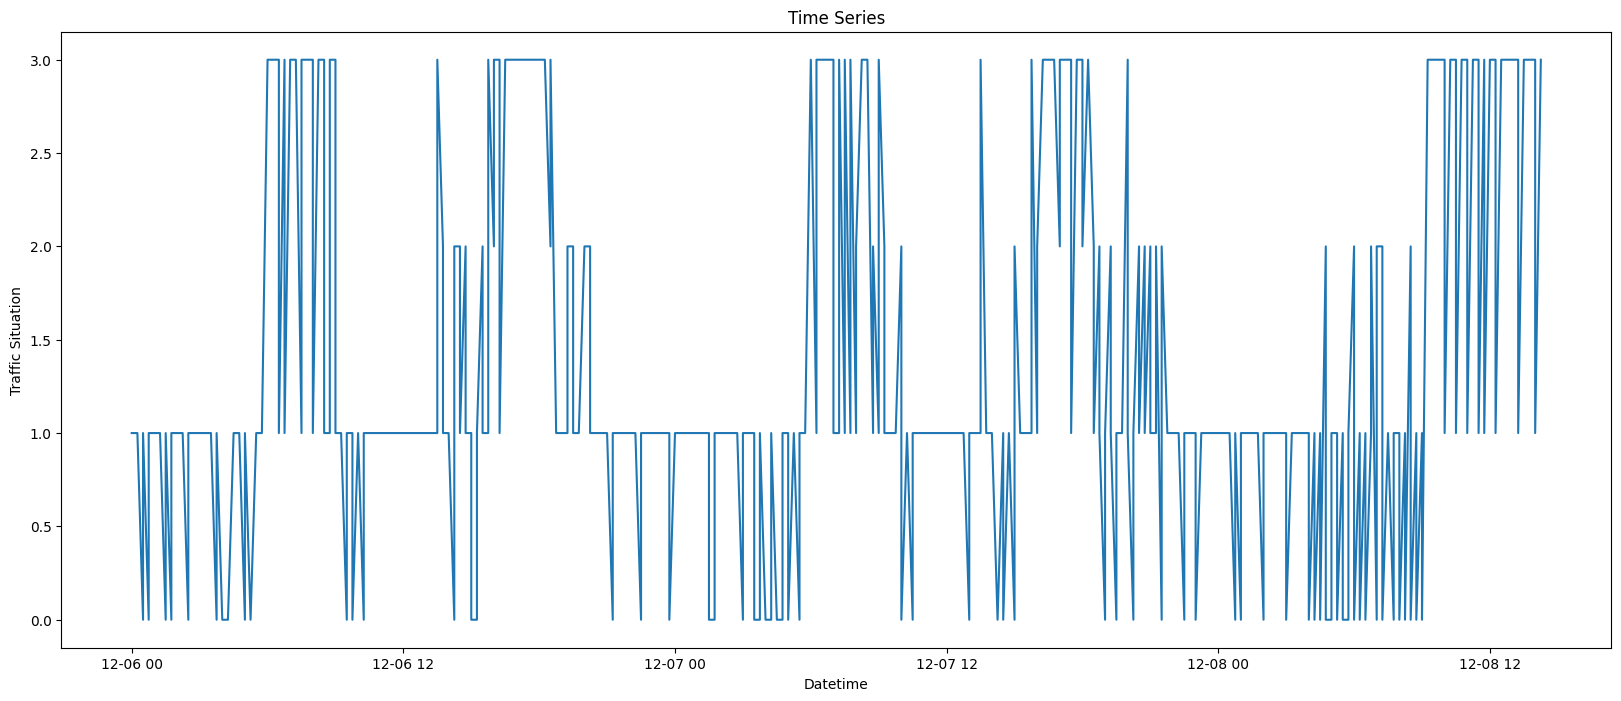

In [41]:
data500 = new_df4.iloc[:500]

plt.figure(figsize=(20,8))
plt.plot(data500)
plt.title('Time Series')
plt.xlabel('Datetime')
plt.ylabel('Traffic Situation')
plt.show()

Phân chia dữ liệu để train model

In [42]:
data = copy.copy(new_df4)
data = data.values
data

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int64)

Dự đoán tình trạng giao thông ngày mai, từ liệu 30 ngày trước

In [43]:
timestep = 30 

X = []
y = []

n = len(data)

for i in range(n - (timestep)):
    X.append(data[i:i+timestep])
    y.append(data[i+timestep])


X = np.asanyarray(X)
y = np.asanyarray(y)


index_test = 5000 # tập test bắt đầu từ index 5000
X_train = X[:index_test,:,:]
X_test = X[index_test:,:,:]
y_train = y[:index_test]    
y_test= y[index_test:]   

Tạo model RNN với Long Short Term Memory

In [44]:
import tensorflow as tf 
import keras
from keras import layers

In [45]:
model = keras.models.Sequential([
    layers.LSTM(32,activation = 'relu', input_shape= (30,1), return_sequences=True),
    layers.LSTM(32, activation='relu', return_sequences=True),
    layers.LSTM(32, activation='sigmoid', return_sequences=False),
    layers.Dense(1)
])

In [46]:
model.compile(optimizer='adam', loss='mse', metrics='MAE')

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Train RNN model

In [49]:
history = model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20


157/157 [==============================] - 8s 22ms/step - loss: 0.6650 - MAE: 0.5918
Epoch 2/20
157/157 [==============================] - 3s 22ms/step - loss: 0.5369 - MAE: 0.5172
Epoch 3/20
157/157 [==============================] - 4s 23ms/step - loss: 0.5193 - MAE: 0.5135
Epoch 4/20
157/157 [==============================] - 6s 37ms/step - loss: 0.5057 - MAE: 0.5148
Epoch 5/20
157/157 [==============================] - 4s 28ms/step - loss: 0.4973 - MAE: 0.5038
Epoch 6/20
157/157 [==============================] - 5s 32ms/step - loss: 0.4928 - MAE: 0.5079
Epoch 7/20
157/157 [==============================] - 5s 32ms/step - loss: 0.4930 - MAE: 0.5091
Epoch 8/20
157/157 [==============================] - 5s 32ms/step - loss: 0.4913 - MAE: 0.5101
Epoch 9/20
157/157 [==============================] - 4s 28ms/step - loss: 0.4845 - MAE: 0.5056
Epoch 10/20
157/157 [==============================] - 5s 30ms/step - loss: 0.4939 - MAE: 0.5098
Epoch 11/20
157/157 [=============================

Plot biểu đồ quan hệ loss và epochs

Text(0.5, 1.0, 'Model Accuracy')

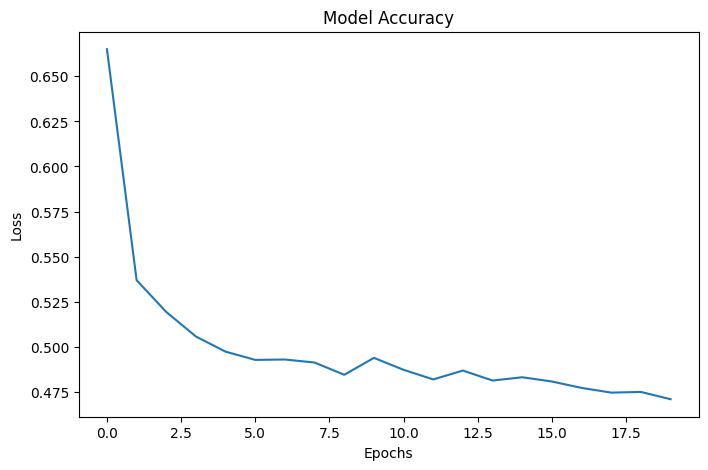

In [50]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

Predict

In [51]:
y_pred = model.predict(X_test).reshape(-1, 1)
y_pred

29/29 [==============================] - 1s 10ms/step


array([[1.0651172 ],
       [0.98898655],
       [1.1386182 ],
       [1.465233  ],
       [1.566001  ],
       [1.3957492 ],
       [1.2756473 ],
       [1.2037278 ],
       [1.0987318 ],
       [1.0573586 ],
       [1.0387621 ],
       [1.0301176 ],
       [0.97598946],
       [1.1587123 ],
       [1.1609219 ],
       [1.0675054 ],
       [1.2503008 ],
       [1.3268154 ],
       [1.2189547 ],
       [1.0988647 ],
       [1.2694186 ],
       [1.2306112 ],
       [1.4548306 ],
       [1.5209426 ],
       [1.3803464 ],
       [1.5453855 ],
       [1.4497964 ],
       [1.357546  ],
       [1.222215  ],
       [1.3816822 ],
       [1.315807  ],
       [1.185766  ],
       [1.1168829 ],
       [1.0265715 ],
       [1.2335948 ],
       [1.246996  ],
       [1.2284265 ],
       [1.8815044 ],
       [2.7191303 ],
       [3.0056016 ],
       [2.9593108 ],
       [2.8641984 ],
       [2.803204  ],
       [2.7736413 ],
       [2.7404711 ],
       [2.6790504 ],
       [2.6157825 ],
       [2.580

Plot biểu đồ giữ giá trị thật sự và dự đoán

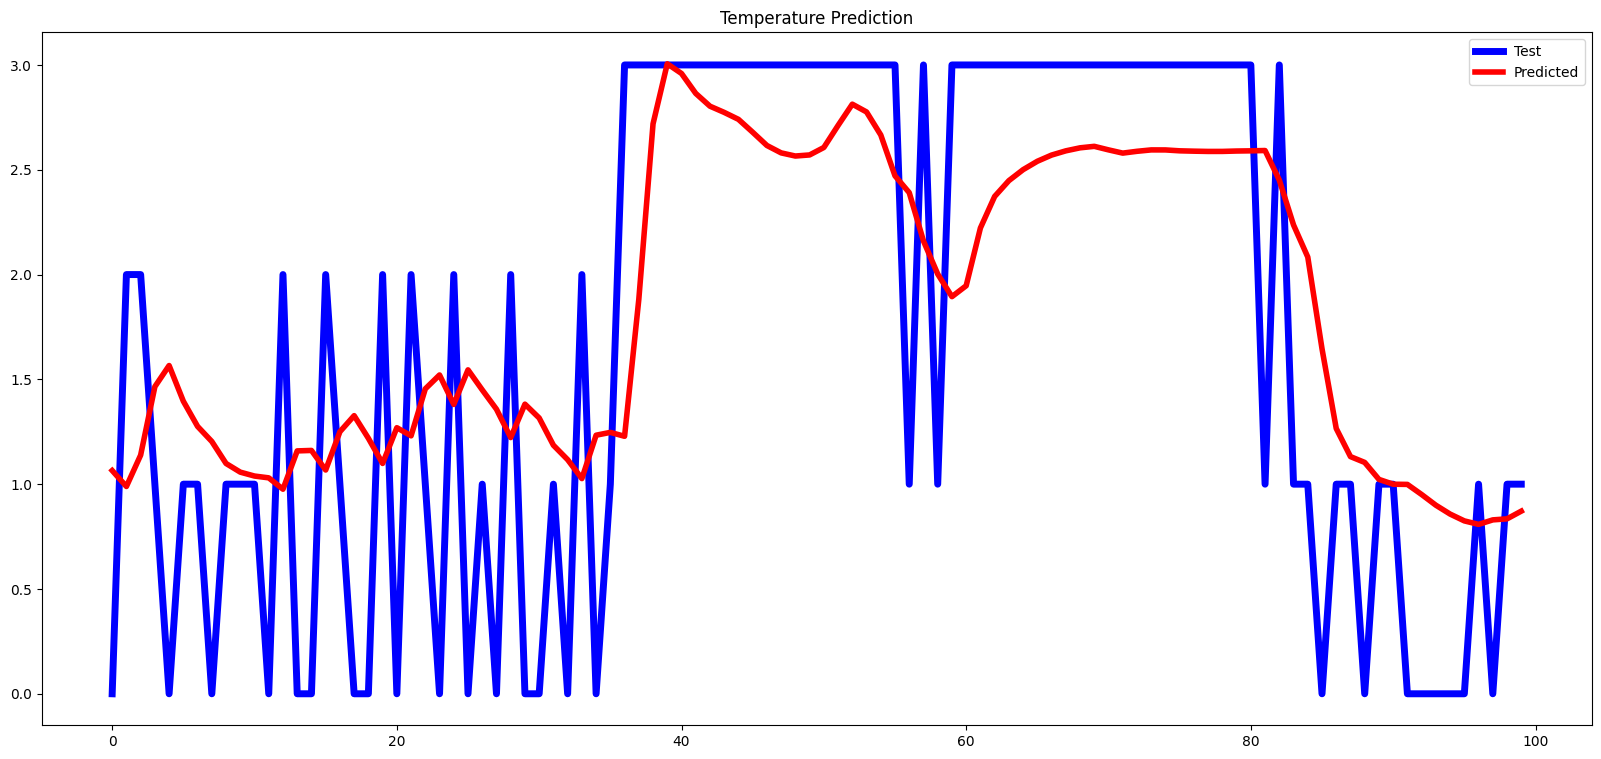

In [52]:
plt.figure(figsize=(20,9))
plt.plot(y_test[:100] , 'blue', linewidth=5)
plt.plot(y_pred[:100],'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Temperature Prediction")
plt.show()

#### Trường hợp 2:

Lấy data là cột Traffic Situation

In [53]:
data = df[['Traffic Situation']]
data = data.values
data

array([['normal'],
       ['normal'],
       ['normal'],
       ...,
       ['normal'],
       ['normal'],
       ['low']], dtype=object)

Encode cột Traffic Situation thành OneHot vì đầu ra là xác suất chữ tiếp theo

In [54]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
data_enc = enc.fit_transform(data).toarray()

Lấy input là một vector có kích thước là 30

In [55]:
timestep = 30

X = []
y = []

n = len(data)

for i in range(n - (timestep)):
    X.append(data_enc[i:i+timestep])
    y.append(data_enc[i+timestep])

X = np.asanyarray(X)
y = np.asanyarray(y)


index_test = 5000
X_train = X[:index_test,:,:]
X_test = X[index_test:,:,:]
y_train = y[:index_test]    
y_test= y[index_test:]  

Train RNN model

In [56]:
import tensorflow as tf 
import keras
from keras import layers

In [57]:
model = keras.models.Sequential([
    layers.LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    layers.Flatten(),
    layers.Dense(4, activation='softmax')
])

In [58]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 32)            4736      
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 3844      
                                                                 
Total params: 8580 (33.52 KB)
Trainable params: 8580 (33.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
history = model.fit(X_train, y_train, epochs=50, verbose=1)

Epoch 1/50


157/157 [==============================] - 4s 12ms/step - loss: 0.9660 - accuracy: 0.6278
Epoch 2/50
157/157 [==============================] - 2s 10ms/step - loss: 0.8313 - accuracy: 0.6928
Epoch 3/50
157/157 [==============================] - 2s 11ms/step - loss: 0.7995 - accuracy: 0.7018
Epoch 4/50
157/157 [==============================] - 2s 10ms/step - loss: 0.7782 - accuracy: 0.7116
Epoch 5/50
157/157 [==============================] - 2s 10ms/step - loss: 0.7623 - accuracy: 0.7148
Epoch 6/50
157/157 [==============================] - 2s 10ms/step - loss: 0.7599 - accuracy: 0.7170
Epoch 7/50
157/157 [==============================] - 2s 10ms/step - loss: 0.7548 - accuracy: 0.7172
Epoch 8/50
157/157 [==============================] - 2s 11ms/step - loss: 0.7457 - accuracy: 0.7200
Epoch 9/50
157/157 [==============================] - 2s 10ms/step - loss: 0.7387 - accuracy: 0.7216
Epoch 10/50
157/157 [==============================] - 2s 10ms/step - loss: 0.7343 - accuracy: 0.7242


Predict

In [61]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1).reshape(-1, 1)
y_test = y_test.argmax(axis=1).reshape(-1, 1)

29/29 [==============================] - 0s 5ms/step


Kết quả dự đoán với giá trị thật

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.80       217
           1       0.00      0.00      0.00        62
           2       0.57      0.26      0.35       151
           3       0.69      0.91      0.78       492

    accuracy                           0.71       922
   macro avg       0.52      0.48      0.48       922
weighted avg       0.65      0.71      0.66       922



#### Kết luận:
Vì dataset không phù hợp cho RNN model, nhưng xét về phần giả định time-series dường như model có phần dự đoán chính xác hơn.

### Overfitting
Sau khi thực hiện huấn luyện mô hình trên tập dữ liệu. Nhận thấy rằng đối với mô hình Feedforward Neural Network, mô hình có xu hướng rất tốt nên không cần phải thực hiện các giải pháp để giảm overfitting. <br>
Đối với mô hình Recurrent Neural Network, mô hình có xu hướng overfitting dựa trên độ đo (metrics) độ chính xác (accuracy ~ 0.6952). Vì vậy, chúng em chọn sử dụng mô hình Recurrent Neural Network để thực hiện giải pháp giảm overfitting. Cụ thể là sử dụng giải pháp Dropout để giảm độ phức tạp của mô hình học máy và Early Stopping. <br>
Giải pháp Early Stopping sẽ giúp ta giảm overfitting bằng cách dừng quá trình huấn luyện mô hình học máy khi độ chính xác trên tập dữ liệu kiểm thử không còn tăng nữa. <br>
Để thực hiện giải pháp Early Stopping, ta sẽ sử dụng EarlyStopping callback của thư viện Keras.

In [66]:
data = df[['Traffic Situation']]
data = data.values
data

array([['normal'],
       ['normal'],
       ['normal'],
       ...,
       ['normal'],
       ['normal'],
       ['low']], dtype=object)

In [67]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
data_enc = enc.fit_transform(data).toarray()

In [68]:
timestep = 30

X = []
y = []

n = len(data)

for i in range(n - (timestep)):
    X.append(data_enc[i:i+timestep])
    y.append(data_enc[i+timestep])

X = np.asanyarray(X)
y = np.asanyarray(y)


index_test = 5000
X_train = X[:index_test,:,:]
X_test = X[index_test:,:,:]
y_train = y[:index_test]    
y_test= y[index_test:]  

In [69]:
from keras.callbacks import EarlyStopping

In [70]:
model_early = keras.models.Sequential([
    layers.LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(4, activation='softmax'),
])

early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)
model_early.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_early.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=100, callbacks=[early_stopping])

Epoch 1/100
50/50 [==============================] - 2s 18ms/step - loss: 1.0632 - accuracy: 0.5966 - val_loss: 1.0346 - val_accuracy: 0.5564
Epoch 2/100
50/50 [==============================] - 1s 13ms/step - loss: 0.9219 - accuracy: 0.6474 - val_loss: 0.9396 - val_accuracy: 0.6453
Epoch 3/100
50/50 [==============================] - 1s 13ms/step - loss: 0.8648 - accuracy: 0.6784 - val_loss: 0.9092 - val_accuracy: 0.6540
Epoch 4/100
50/50 [==============================] - 1s 13ms/step - loss: 0.8322 - accuracy: 0.6956 - val_loss: 0.8772 - val_accuracy: 0.6725
Epoch 5/100
50/50 [==============================] - 1s 15ms/step - loss: 0.8118 - accuracy: 0.6956 - val_loss: 0.8527 - val_accuracy: 0.6876
Epoch 6/100
50/50 [==============================] - 1s 13ms/step - loss: 0.8030 - accuracy: 0.7024 - val_loss: 0.8418 - val_accuracy: 0.6887
Epoch 7/100
50/50 [==============================] - 1s 13ms/step - loss: 0.7895 - accuracy: 0.7088 - val_loss: 0.8378 - val_accuracy: 0.6931
Epoch 

#### Kết quả
Sau khi thực hiện giải pháp Dropout (để giảm độ phức tạp của mô hình) và Early Stopping, độ chính xác trên tập dữ liệu huấn luyện đã giảm từ 0.6875 xuống 0.6765. Tuy nhiên, độ chính xác trên tập dữ liệu kiểm thử vẫn giữ nguyên ~ 0.6952. Điều này chứng tỏ mô hình đã không còn overfitting nữa. <br>
Trước khi thực hiện giải pháp Dropout và Early Stopping:
```terminal
...
Epoch 199/200
48/48 [==============================] - 0s 6ms/step - loss: 0.8547 - accuracy: 0.6856 - val_loss: 0.8476 - val_accuracy: 0.6952
Epoch 200/200
48/48 [==============================] - 0s 5ms/step - loss: 0.8547 - accuracy: 0.6875 - val_loss: 0.8468 - val_accuracy: 0.6952
```
Sau khi thực hiện giải pháp Dropout và Early Stopping:
```terminal
...
Epoch 199/200
48/48 [==============================] - 0s 5ms/step - loss: 0.8747 - accuracy: 0.6776 - val_loss: 0.8474 - val_accuracy: 0.6952
Epoch 200/200
48/48 [==============================] - 0s 6ms/step - loss: 0.8771 - accuracy: 0.6765 - val_loss: 0.8473 - val_accuracy: 0.6952
```

### Cải thiện độ chính xác
Để thay đổi độ chính xác đối với mô hình (cụ thể là mô hình Recurrent Neural Network), ta sẽ thực hiện các giải pháp sử dụng LSTM (Long Short-Term Memory) đa chiều (Bidirectional LSTM). <br>
#### Giải pháp sử dụng LSTM đa chiều
Giải pháp sử dụng LSTM đa chiều sẽ giúp ta cải thiện độ chính xác bằng cách sử dụng LSTM đa chiều (Bidirectional LSTM) thay vì sử dụng LSTM đơn chiều (LSTM). <br>
Qua đó, lớp LSTM đa chiều (Bidirectional LSTM) sẽ giúp ta cải thiện độ chính xác bằng cách xem xét cả thông tin từ quá khứ và tương lai. <br>
Để thực hiện giải pháp sử dụng LSTM đa chiều, ta sẽ sử dụng lớp Bidirectional của thư viện Keras. <br>

In [72]:
model_bid = keras.models.Sequential([
    layers.Bidirectional(layers.LSTM(128, activation='relu', input_shape=(X_train.shape[1], 1))),
    layers.Dense(4, activation='softmax'),
])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_bid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_bid.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=100, callbacks=[early_stopping])

Epoch 1/100
50/50 [==============================] - 6s 79ms/step - loss: 1.0491 - accuracy: 0.6048 - val_loss: 1.0015 - val_accuracy: 0.5933
Epoch 2/100
50/50 [==============================] - 4s 82ms/step - loss: 0.9033 - accuracy: 0.6644 - val_loss: 0.8653 - val_accuracy: 0.6920
Epoch 3/100
50/50 [==============================] - 4s 87ms/step - loss: 0.8564 - accuracy: 0.6846 - val_loss: 0.8755 - val_accuracy: 0.6757
Epoch 4/100
50/50 [==============================] - 5s 96ms/step - loss: 0.8077 - accuracy: 0.7074 - val_loss: 0.8364 - val_accuracy: 0.7104
Epoch 5/100
50/50 [==============================] - 4s 86ms/step - loss: 0.7927 - accuracy: 0.7094 - val_loss: 0.8173 - val_accuracy: 0.7093
Epoch 6/100
50/50 [==============================] - 4s 86ms/step - loss: 0.7827 - accuracy: 0.7126 - val_loss: 0.8322 - val_accuracy: 0.7061
Epoch 7/100
50/50 [==============================] - 4s 86ms/step - loss: 0.7764 - accuracy: 0.7174 - val_loss: 0.8174 - val_accuracy: 0.7148
Epoch 

#### Kết quả
Sau khi thực hiện giải pháp sử dụng LSTM đa chiều, độ chính xác trên tập dữ liệu kiểm thử đã tăng lên ~ 0.6969 (từ 0.6952) trong khi độ chính xác trên tập dữ liệu huấn luyện đã giảm xuống ~ 0.6845 (từ 0.6875). <br>
Mặc dù độ chính xác tăng lên không nhiều, nhưng độ ổn định, và hiệu suất học của mô hình đã được cải thiện. Cụ thể, từ sau epoch thứ 50, độ chính xác của mô hình đã không còn thay đổi và biến động nhiều như trước đó. Trong khi đó, độ chính xác của mô hình trước khi thực hiện giải pháp sử dụng LSTM đa chiều chỉ ổn định sau epoch thứ 100. Điều này vừa giúp ta tiết kiệm được thời gian huấn luyện mô hình, vừa giúp ta có thể tăng độ chính xác của mô hình. Ta cũng có thể áp dụng thêm Early Stopping để giảm thời gian huấn luyện mô hình khi độ chính xác của mô hình không còn thay đổi và biến động nhiều như trước đó. <br>
Sau khi thực hiện giải pháp sử dụng LSTM đa chiều:

Đánh giá kết quả sau khi train.\
Nhìn chung RNN model sau khi áp dụng các kĩ thuật cải thiện thì có tỉ lệ dự đóan cao hơn một ít.

In [73]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

29/29 [==============================] - 0s 5ms/step - loss: 0.7918 - accuracy: 0.7082
Loss: 0.791769802570343, Accuracy: 0.7082429528236389


In [74]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_test = y_test.argmax(axis=1)
y_pred

29/29 [==============================] - 0s 5ms/step


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.80       217
           1       0.00      0.00      0.00        62
           2       0.57      0.26      0.35       151
           3       0.69      0.91      0.78       492

    accuracy                           0.71       922
   macro avg       0.52      0.48      0.48       922
weighted avg       0.65      0.71      0.66       922

